# Xylariaceae analysis, take 2

We're going to do our RDA analysis using a biom table that contains only fungi that were very strictly assigned to our stomatal sequences. Since the focus is on ecological patterns in our leaf data, and meant to augment Roo's single variate, Nearest-Neighbor spatial analysis, we'll use his otu tables. 

<a id='contents'></a>

## Contents

[Importing otu tables and setup](#import)  
[Formatting inputs for RDA](#rdaprep)  
[Transforming data for RDA](#transform)  
[Redundancy analysis](#rda)  
[Graphics](#graphics)

<a id='import'></a>

## Importing otu tables and setup

Let's get the proper packages and import our biom table.

In [1]:
library('repr')
library('vegan')

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-1


Import our leaf endophyte OTU table. Negative controls have been used to "clean" the other samples, and the reads have been variance-stabilized using DESeq, prior to delivery. 

In [2]:
roocsv <- read.csv(file='roo_leaf_endos.csv', stringsAsFactors=FALSE)
endos <- roocsv

In [3]:
endos[1:5,1:5]

Plot.ID,A_aff_atroroseum,A_aff_stygium,A_atroroseum,A_bovei_var_microspora
1,0,0,0,0
2,0,0,0,0
3,NA,NA,NA,NA
4,0,0,0,0
5,0,0,0,0


NA rows are where amplification failed. We got rid of the first column, Plot.ID, because this is redundant with the row numbers, and will cause problems with the RDA downstream. Also we still have a negative control here, we'll remove it. 

In [4]:
endos <- endos[,-1]
endos <- endos[-134,] ## get rid of negative control

And get our stromatal matrix. The [rda()](https://cran.r-project.org/web/packages/vegan/vignettes/intro-vegan.pdf) function likes a community matrix, and a dataframe of constraining explanatory variables. So the endos stay as a dataframe object, and the stromata as a matrix.

In [5]:
stromata <- read.csv(file='stromata.csv', stringsAsFactors=FALSE) 
stromata <- as.matrix(stromata[,-1]) ## remove plot name column, cuz it screws up conversion to matrix format

In [6]:
stromata[1:10,1:5]

A_aff_atroroseum,A_aff_stygium,A_atroroseum,A_bovei_var_microspora,A_moriforme
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0
0,0,0,0,0


Name rows:

In [7]:
rownames(stromata) <- rownames(endos) <- 1:133

In [8]:
stromata[1:3,1:3]

,A_aff_atroroseum,A_aff_stygium,A_atroroseum
1,0,0,0
2,0,0,0
3,0,0,0


In [9]:
endos[1:3,1:3]

A_aff_atroroseum,A_aff_stygium,A_atroroseum
0,0,0
0,0,0
NA,NA,NA


Not trying to be to anal here, but we need to be careful. Check to make sure column names match and the row names are the same and in the same order:

In [10]:
colnames(endos) %in% colnames(stromata)
colnames(stromata) %in% colnames(endos)
rownames(endos) == rownames(stromata)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

<a id='rdaprep'></a>

To examine the importance of leaf in predicting decomposer (stromata) populations, we'll employ [Redundancy analysis](https://sites.google.com/site/mb3gustame/constrained-analyses/rda). This is a constrained, direct-gradient type of analysis that is kind of like a multiple regression of a response (Y) matrix to several explanatory (X) matrices.  

One of the nice things about RDA is that it is constrained, meaning that it focuses on the variation in our response matrix that can be explained by the variables we supply, though there is some estimation of unexplained variation. We do not expect that all or even most of the variation in our decomposer matrix will be explained by either the leaf endophyte populations. Much of the variation is probably due to environmental conditions, etc. But here we check to see if any variation in our decomposers can be predicted by endophytes. 

This is a low-resolution test, we won't pay a lot of attention to the individual species here, because we're not weighting them by sample size or spatial proximity. The RDA in this case is the first step in testing our hypothesis that the endophytes are affecting the stromata, following by the many, much more specific spatial tests using nearest neighbor methods. 

### Formatting inputs for RDA

Our response matrix will be the observations of stromata from our sites. The explanatory matrix will be our leaf endophyte species matrix. Both need to be of the same sites and of the same fungi, meaning we need to trim the rows to match. Also, we need to remove zero-sum columns (i.e. species that were not observed) and rows where endophyte sampling failed will need to be removed from both. So this is a three step process: (1) remove NA rows from both matrices, (2) remove species from both matrices that were not observed at least once (3) trim both matrices' columns to each other, so that only shared species remain. 

Then see what's left standing, and hope it's enough to build an informative model.


Rows:

In [11]:
aa <- !(is.na(endos[,1])) ## which rows in the endophytes were successfully sampled? (= not NA's)
stromata <- stromata[aa,] ## remove endophyte NA rows from stromata
endos <- endos[aa,] ## and from the endophytes

Removing stromata zero columns:

In [12]:
aa <- which(colSums(stromata) != 0) ## which Xylariaceous species are actually observed as stromata in at least one plot
stromata <- stromata[,aa]
any(colSums(stromata) == 0) ## check, did it work?

[1] FALSE

Removing endophyte zero rows:

In [13]:
aa <- which(colSums(endos) != 0) ## which Xylariaceous species are actually observed as endophytes in leaves in at least one plot
endos <- endos[,aa]
any(colSums(endos) == 0) ## check, did it work?

[1] FALSE

In [14]:
sum(colnames(endos) %in% colnames(stromata)) ## how many species do we have in common

[1] 18

Huh. Fewer I'd thought. 

Pare both matrices down to the same columns:

In [15]:
aa <- colnames(stromata) %in% colnames(endos)
bb <- colnames(endos) %in% colnames(stromata)

stromata <- stromata[,aa]
endos <- endos[,bb]

In [16]:
dim(stromata)
dim(endos)

[1] 115  18

[1] 115  18

In [17]:
colnames(stromata) == colnames(endos)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE

In [18]:
rownames(stromata) == rownames(endos)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

Looks good, matrices are the same size, same column and row orders...

<a id='transform'></a>

## Data transformations

** 1. Convert to Presence/Absence data:** Doing to this because I do not trust our read abundances or stromata counts to be ecologically meaningful. See notes [here](#mockcom).

In [19]:
stromata[stromata > 0] <- 1
endos[endos > 0] <- 1

**2. Hellinger transformations:** 

Redundancy analysis is a type of PCA of our response (stromata) matrix coupled with a multiple regression of our explanatory matrix, in this case either our wood or leaf endophyte matrices. (RDA is obviously a lot more complicated than this, involving construction of new axes informed by both explanatory and response variable, see [here](#https://sites.google.com/site/mb3gustame/constrained-analyses/rda)). Since this can be considered a type of multiple regression and PCA analysis, we run into some obstacles. PCA analysis relies on Euclidean distances for its construction of new axes, and multiple regression works best when the explanatory variables can be modeled linearly, or at least ordered in rank abundance. But it's pretty well known that species distributions aren't modeled well as linear gradients. Along a single environmental gradient they may follow unimodal, gaussian distibutions, but in really sparse matrices like we have, with incomplete sampling of thousands of interacting species instead of one, and in the finite space of a single study with environmental variables varying at different spatial scales, this type of normality can be pretty hard to pick up. Also the numerous zeroes in these matrices make very different sampling sites look very similar in normal euclidean space, [the double zero problem](#https://sites.google.com/site/mb3gustame/reference/dissimilarity).

So we'll standardize and flatten out differences in abundances in our species matrices using a [Hellinger transformation](#http://www.jstor.org/stable/4223083). In doing so we hope to reduce the homogenizing effect of having lots of zeroes in all sites and retain monotonic properties, if not linearity, to our abundance data (which we've already reduced to presence-absence). The RDA can then proceed with these transformed values to create new axes that are shared by both our explanatory and response matrices, using euclidean distances. At least, that's the theory...

In [20]:
stromata.hel <- decostand(stromata, 'hellinger')
endos.hel <- decostand(endos, 'hellinger')

In [21]:
#save(stromata, file='stromata.rda')
#save(endos, file='endos.rda')

#save(stromata.hel, file='stromata.hel.rda')
#save(endos.hel, file='endos.hel.rda')

<a id='rda'></a>

# Redundancy Analysis

Okay, think we're done with formatting and transformations. Time to do the deed:

**Stromata as a function of entire leaf endophyte community**

In [8]:
leaf.rda <- rda(stromata.hel ~ ., data = endos.hel) ## run the rda

In [9]:
anova.cca(leaf.rda, permutations = 10000) ## check for significance

,Df,Variance,F,Pr(>F)
Model,18,0.06033647,1.356065,0.04389561
Residual,96,0.23730024,NA,NA


Not a lot of variance explained, but we weren't expecting much, as "viaphytism" is just one reason to live in a leaf. Look at our RDAs:

In [11]:
leaf.rda

Call: rda(formula = stromata.hel ~ A_atroroseum +
A_bovei_var_microspora + A_moriforme + B_capnodes_1 + H_notatum +
H_perforatum_China + K_pavimentosa + K_pavimentosa_or_N_primolutea +
N_bipapillata_var_bipapillata + N_bipapillata_var_macrodiscus +
N_diffusa + N_sp_1 + W_microplaca + X_atrosphaerica + X_flabelliforme +
X_schweinitzii + X_sp_1 + X_sp_nov_1_long, data = endos.hel)

              Inertia Proportion Rank
Total         0.29764    1.00000     
Constrained   0.06034    0.20272   17
Unconstrained 0.23730    0.79728   18
Inertia is variance 

Eigenvalues for constrained axes:
    RDA1     RDA2     RDA3     RDA4     RDA5     RDA6     RDA7     RDA8 
0.021076 0.009911 0.009357 0.004949 0.003513 0.003352 0.002402 0.001661 
    RDA9    RDA10    RDA11    RDA12    RDA13    RDA14    RDA15    RDA16 
0.001277 0.000935 0.000696 0.000379 0.000336 0.000239 0.000133 0.000088 
   RDA17 
0.000034 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5     PC6     PC7     

Which of these RDA's are statistically significant?

In [19]:
anova_axis<-anova(leaf.rda,by="axis")
anova_axis

,Df,Variance,F,Pr(>F)
RDA1,1,2.107571e-02,8.61500872,0.001
RDA2,1,9.911092e-03,4.05130631,0.007
RDA3,1,9.356885e-03,3.82476575,0.002
RDA4,1,4.949327e-03,2.02311086,0.049
RDA5,1,3.512714e-03,1.43587418,0.238
RDA6,1,3.351741e-03,1.37007399,0.182
RDA7,1,2.401561e-03,0.98167380,0.385
RDA8,1,1.661286e-03,0.67907523,0.723
RDA9,1,1.276855e-03,0.52193333,0.866
RDA10,1,9.345910e-04,0.38202799,0.950


So only the first four RDAs are statistically significant. 

In [12]:
#save(leaf.rda, file='leafrda.rda')

<a id='graphics'></a>

## Graphics

There is a quick plotter for these kinds of constrained ordinations, which takes the first two rdas:

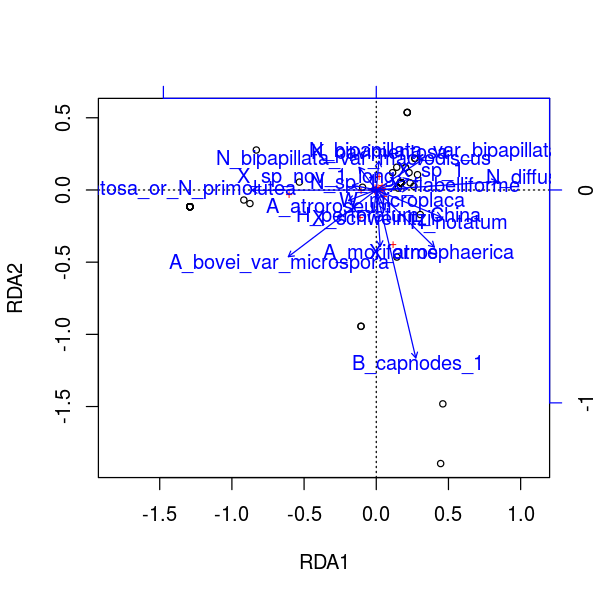

In [17]:
options(repr.plot.width = 5, repr.plot.height = 5)
leafrdaplot <- plot(leaf.rda)

In these plots, species from our wood or leaf matrix are arrows. RDA is a type of constrained analysis, so the wood endophyte species are being used in the construction of the two most important PCA's (RDA's) that are our two axes. The longer the arrow, the more important they are for these new RDA axes. Hence, the longer arrows indicate which leaf endophytes seem to be co-varying with our stromata community.However, if we look at our RDA's, the second ("y" axis) is far less important and pretty arbitrary, the RDA's after the first one are in the same order of magnitude.

So for the moment, let's focus on this first RDA, where most of the information is. Not sure where the loadings for the RDA's are kept in the model, but they are in the plot object, we can grab them from there:

In [13]:
head(leafrdaplot$biplot)

,RDA1,RDA2
A_atroroseum,-0.13031924,-0.04945629
A_bovei_var_microspora,-0.41283831,-0.31318943
A_moriforme,0.01852943,-0.26392204
B_capnodes_1,0.18551848,-0.78847767
H_notatum,0.30504264,-0.12732847
H_perforatum_China,0.04059997,-0.09363635


Okay, here's a quick and dirty function for grabbing one of these RDAs and plotting them in spiral arrangement. Uses three arguments - the rda plot object, the rda number, and the number of species desired from this rda. The setting for the x and y limits may need to be altered, but if so, range and domain should be equal to avoid biasing the lengths of the arrows. 

In [14]:
oneRDAplot <- function(rdaplot, rdanum, speciesnum){
        ## empty plot
        plot(1, type = 'n', xlim=c(-0.5,0.8), ylim=c(-0.5,0.8), axes=FALSE, xlab="",ylab="")
        ## get RDA
        aa <- rdaplot$biplot[,rdanum]
        ## magnitude, not direction, really matters here:
        bb <- sort(abs(aa), decreasing=TRUE)
        ## take out the number of species desired:
        cc <- bb[1:speciesnum]
        ## first create a set of angles:
        ang <- NULL
        ang[1] <- 90
        for (i in 2:speciesnum){
                ang[i] <- ang[i-1] - 360/speciesnum
                if(ang[i] < 0) {ang[i] <- ang[i] + 360}
        }
        ang <- ang*pi/180 ## convert to radians, these are our angles
        ## now create a set of x and y coords using our angles
        ## we need to multiply by the loadings from our RDA ('cc')
        x1 <- cc*cos(ang)
        y1 <- cc*sin(ang)
        ## and plot these arrows:
        arrows(x0=0,y0=0,x1,y1, length=.1)
        return(cc) ## give back sorted list
} ## end of function

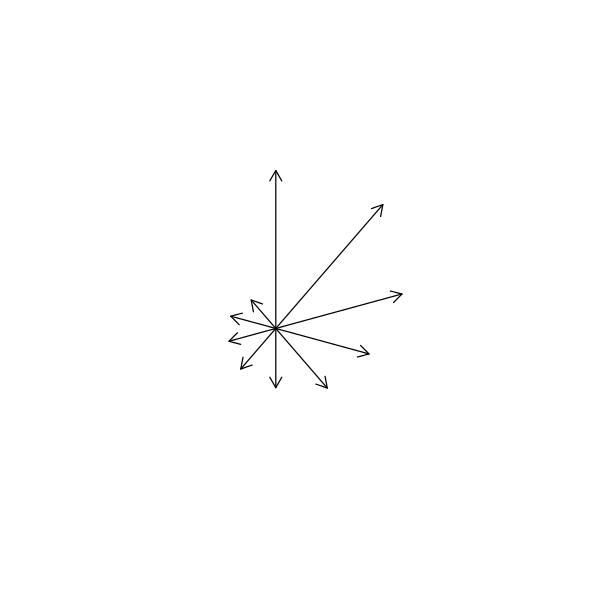

In [15]:
aa <- oneRDAplot(leafrdaplot, 1, 10)

In [16]:
aa

K_pavimentosa_or_N_primolutea                     N_diffusa 
                    0.5848196                     0.5668461 
       A_bovei_var_microspora                     H_notatum 
                    0.4128383                     0.3050426 
              X_atrosphaerica N_bipapillata_var_bipapillata 
                    0.2726107                     0.2190221 
                 B_capnodes_1                        X_sp_1 
                    0.1855185                     0.1530396 
              X_flabelliforme                  A_atroroseum 
                    0.1474034                     0.1303192

So that is one way of presenting our results, using just the first RDA. If we want to plot other RDA's beyond RDA1 and RDA2, we need to dig into our RDA object a little more. We'll look at the first four, which were the only statistically significant ones:

In [20]:
loads <- leaf.rda$CC$biplot[,1:4]

In [23]:
head(loads)

,RDA1,RDA2,RDA3,RDA4
A_atroroseum,-0.13031924,-0.04945629,0.16266511,-0.13636009
A_bovei_var_microspora,-0.41283831,-0.31318943,0.45615937,0.07457499
A_moriforme,0.01852943,-0.26392204,0.60477528,0.05000369
B_capnodes_1,0.18551848,-0.78847767,-0.40629779,0.14173948
H_notatum,0.30504264,-0.12732847,-0.08635277,-0.25582810
H_perforatum_China,0.04059997,-0.09363635,0.33955652,0.06478961


These are all of the shared PCAs useful for describing variation in both stromata and endophyte matrices. We can use these to make our own biplots. To plot the first RDA as our y-axis and the second RDA as our x-axis:

In [25]:
symb <- LETTERS[1:18]

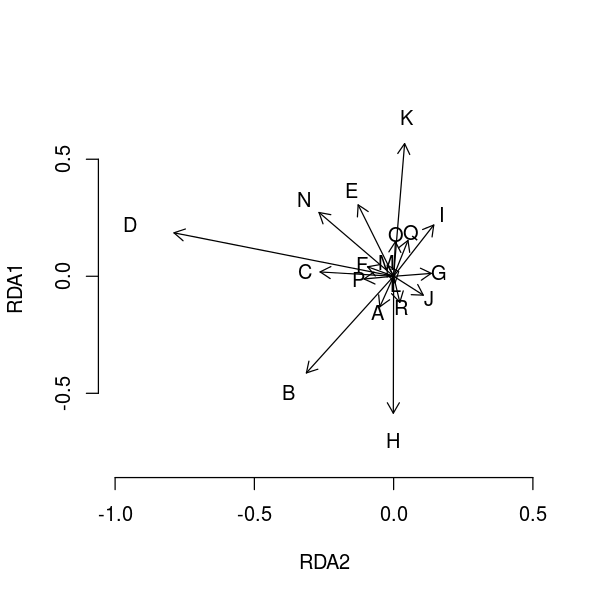

In [27]:
## set coordinates for text:
textx <- loads[,2]*1.2
texty <- loads[,1]*1.2
#svg("RDA2RDA1.svg")
plot(1, type='n', xlim=c(-1,.5), ylim=c(-.8,.7), xlab='RDA2', ylab='RDA1', bty='n')
arrows(x0=0, y0=0, x1=loads[,2], y1=loads[,1], length=.1) ## rda1 is our y-axis, rda2 is x-axis
text(textx,texty, symb)

Export as an svg, do a little magic with inkscape, and voila:

<img src='RDA2RDA1.png', width=500,height=500>

We can do the same with the 3rd and 4th RDA axes. Looks like this:

<img src='RDA3RDA4.png', width=500, height=500>